<a href="https://colab.research.google.com/github/rukka0808/Deep-Learning-Study/blob/main/Use_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras

import IPython

In [ ]:
! pip install -U keras-tuner

In [4]:
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [5]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
#Normalize pixel 0 to 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype("float32") / 255.0

In [7]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

32-512 사이에 value 를 고름 
하이퍼모델을 만들어서 모델을실행

In [12]:
tuner = kt.Hyperband(model_builder, 
                      objective='val_accuracy',
                      max_epochs=10,
                      factor=3,
                      directory='my_dir',
                      project_name='FirstKT')

In [11]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
   def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)   

output을 지워줌

In [13]:
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.8834999799728394

Best val_accuracy So Far: 0.8877000212669373
Total elapsed time: 00h 08m 53s
INFO:tensorflow:Oracle triggered exit


unit 과 learning rate 가 변한다.

In [20]:
best_hps

In [21]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [25]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=10, validation_data= (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4855 - accuracy: 0.8274 - val_loss: 0.4276 - val_accuracy: 0.8466
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3643 - accuracy: 0.8680 - val_loss: 0.4258 - val_accuracy: 0.8469
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3266 - accuracy: 0.8805 - val_loss: 0.3588 - val_accuracy: 0.8720
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3025 - accuracy: 0.8885 - val_loss: 0.3495 - val_accuracy: 0.8755
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2858 - accuracy: 0.8932 - val_loss: 0.3569 - val_accuracy: 0.8721
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2724 - accuracy: 0.8985 - val_loss: 0.3529 - val_accuracy: 0.8714
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2589 - accuracy: 0.9035 - val_loss: 0.3368 - val_accuracy:

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

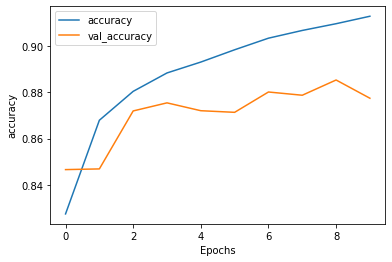

In [26]:
plot_graphs(history, 'accuracy')

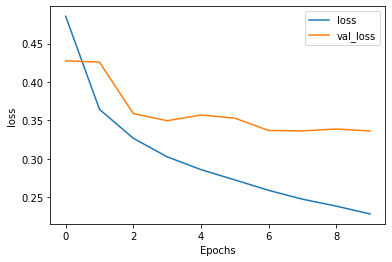

In [27]:
plot_graphs(history, 'loss')